# CNNs
Credits Charles Deledalle  
Adapted by Aurélie Bugeau




CNNs are specific artificial neural networks composed of *convolutional* layers, *maxpooling* operations, and
*fully connected* layers.
- Convolutional layers are like typical layers where the weight matrix has a specific structure that is relevant for signals and images.  
They take as input $N$ images and produce as output $C$ images (called *feature maps* or *channels*).   
They are parameterized by a collection of coeficients that defines a filter bank. Each filter performs a weighted average of its inputs within local sliding windows of size $K \times K$  (pixels) where $K$ is a hyperparameter (a small odd number: 3, 5, 7, 9).  
As for classical layers in neural networks, each feature map is next processed by an activation function such as  ReLU.  
  
  
- Maxpooling operations reduce the dimensions of each feature map by picking the maximum value within local but non-overlapping sliding windows of size $L \times L$ (pixels) where $L$ is another hyper- parameter (usually 2). Maxpooling does not introduce new parameters to be learned.  

  
  
- Fully connected layers are standard layers where the weight matrix does not have a specific structure: each of the $N$ output units is connected to each of the $M$ input units.

## 1 - Preparing the dataset

In this practice, you will experiment a CNNs on MNSIT

In [13]:
# Load modules
import numpy as np
import torch
import matplotlib.pyplot as plt
import MNISTtools
import torch.nn as nn
import torch.nn.functional as F

Let us first load and normalize MNIST testing and training data.

In [36]:
def normalize_MNIST_images(x):
    return 2 * x.astype(np.float32) / 255. - 1

xtrain, ltrain = MNISTtools.load(dataset = "training")
xtrain = normalize_MNIST_images(xtrain)

xtest, ltest = MNISTtools.load(dataset='testing')
xtest = normalize_MNIST_images(xtest)

#### Questions 1
Torch expects that the input of a convolutional layer is stored in the following format
  $$
  \texttt{Batch size} \times \texttt{Number of input channels} \times \texttt{Image height} \times \texttt{Image width}
  $$
  
The number of input channels in our case is 1 because MNIST is composed of grayscale images. It would have been 3 if the images were in RGB color.
In deeper layers, the number of input channels will be the number of input feature maps.

Reorganise the tensors _xtrain_ and _xtest_ accordingly.
Hint:
  Reshape them first with shape $\texttt{(28, 28, 1, 60000)}$ and $\texttt{(28, 28, 1, 10000)}$
  respectively and then use $\texttt{np.moveaxis}$.

In [37]:
xtrain = np.reshape(xtrain, (28,28,1,60000))
xtrain = np.moveaxis(xtrain,-2,0)
xtrain = np.moveaxis(xtrain,-1,0)
print(xtrain.shape)

xtest = np.reshape(xtest, (28,28,1,10000))
xtest = np.moveaxis(xtest,-2,0)
xtest = np.moveaxis(xtest,-1,0)
print(xtest.shape)


(60000, 1, 28, 28)
(10000, 1, 28, 28)


Check that your data are well reorganized by making sure that `MNISTtools.show(xtrain[42, 0, :, :])` displays a digit that indeed corresponds to `ltrain[42]`

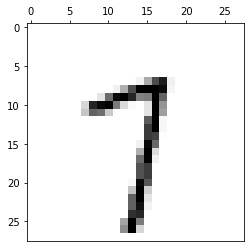

7


In [38]:
MNISTtools.show(xtrain[42, 0, :, :])
print(ltrain[42])

In [39]:
print(ltrain.shape)

(60000,)


Finally wrap all the data into torch Tensor

In [40]:
xtrain = torch.from_numpy(xtrain)
ltrain = torch.from_numpy(ltrain)
xtest = torch.from_numpy(xtest)
ltest = torch.from_numpy(ltest)

## 2- Convolutional Neural Network (CNN) for MNIST classification

Neural networks can be constructed using the _torch.nn_ package, which
relies on _autograd_ differentiation tools.
This package provides an implementation of CNNs as follows:

* Convolutional layers can be created as `nn.Conv2d(N, C, K)`.
  For input images of size $W \times H$, the output feature maps have size $[W-K+1] \times [H-K+1]$.
* In PyTorch, maxpooling is implemented like any other non-linear function (such as
  `RELU` or `softmax`.
  For input images of size $W \times H$, the output feature maps
  have size $\lceil W/L \rceil \times \lceil H/L \rceil$.
* A fully connected layer can be created as `nn.Linear(M, N)`.

#### Question 2 
Our LeNet network will be composed successively of
   1. a convolutional layer (i) connecting the input image to 6
    feature maps with $5 \times 5$ convolutions ($K = 5$) and followed
    by ReLU and maxpooling (ii) ($L=2$),
   2. a convolutional layer (iii) connecting the 6 input channels to 16
    output channels with $5 \times 5$ convolutions and followed
    by ReLU and maxpooling (iv) ($L=2$),
   3. a fully-connected layer connecting $16$ feature maps
    to $120$ output units and followed by RELU,
   4. a fully-connected layer connecting $120$ inputs
    to $84$ output units and followed by RELU,
   5. a final linear layer connecting $84$ inputs
    to $10$ linear outputs (one for each of our digits).

Determine the size of the feature maps after each convolution and maxpooling operation i.e. at points (i)-(iv) processing steps. 



#!Complete

#### Question 3
Interpret and complete the following code initializing our LeNet network. 

Note that you just have to define the forward function, and the backward function (where gradients are computed) will be automatically defined for you using _autograd_.
You can use any of the Torch tensor operations in the forward function.
For more details, please refer to \url{https://pytorch.org/docs/stable/nn.html}


In [78]:
# The neural networks class
class LeNet(nn.Module):

    # define our network structure
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6 , 5)
        self.conv2 = nn.Conv2d(6, 16 , 5)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # define one forward pass through the network
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (5, 5))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # Thelper function to understand the dimensions
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        return np.prod(size)

net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### Question 4
Run the following and interpret the results. What are the learnable parameters?  Are gradients going to be tracked by _autograd_ for all parameters?

In [79]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)  

conv1.weight torch.Size([6, 1, 5, 5]) True
conv1.bias torch.Size([6]) True
conv2.weight torch.Size([16, 6, 5, 5]) True
conv2.bias torch.Size([16]) True
fc1.weight torch.Size([120, 16]) True
fc1.bias torch.Size([120]) True
fc2.weight torch.Size([84, 120]) True
fc2.bias torch.Size([84]) True
fc3.weight torch.Size([10, 84]) True
fc3.bias torch.Size([10]) True


#### Runnung a foward pass
To run a forward pass of your initial network over your testing set, simply run the following code. 

Note that `with torch.no\_grad()` is used to avoid tracking for
gradient during testing and then save some computation time
(refer to \url{https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad}).



In [82]:
with torch.no_grad():
    yinit = net(xtest) #equivalent to  yinit = net.forward(xtest)


#### Question 5
Run the following and interpret the result

In [83]:
_, lpred = yinit.max(1)
print(100 * (ltest == lpred).float().mean())

tensor(4.8800)


#! COmplete


#### Question 6
We will use (Mini-Batch) Stochastic Gradient Descent (SGD) with cross-entropy and momentum.
Complete the following function.

For more details, refer to
\url{https://pytorch.org/docs/stable/nn.html} and
\url{https://pytorch.org/docs/stable/optim.html}.
Note that PyTorch's CrossEntropyLoss is the composition of a softmax activation with the standard cross-entropy loss.



In [100]:
# T: number of epochs
# B: minibatch size, 
# gamma: step size,
# rho: momentum.
def backprop_deep(xtrain, ltrain, net, T, B=100, gamma=.001, rho=.9):
    N = xtrain.size()[0]        # Training set size
    NB = 500   # Number of minibatches
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=rho)
    for epoch in range(T):
        running_loss = 0.0
        shuffled_indices = np.random.permutation(range(N))
        for k in range(NB):
            # Extract k-th minibatch from xtrain and ltrain
            minibatch_indices = shuffled_indices[B*k:min(B*(k+1), N)]
            inputs = xtrain[minibatch_indices]
            labels = ltrain[minibatch_indices]

            # Initialize the gradients to zero
            optimizer.zero_grad()

            # Forward propogation
            outputs = net(inputs) 

            # Error evaluation
            loss = criterion(outputs, labels)

            # Back propogation
            loss.backward()

            # Optimize step
            optimizer.step()

            # Compute and print statistics
            with torch.no_grad():
                running_loss += loss
            if k % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, k + 1, running_loss / 100))
                running_loss = 0.0


#### Question 7

Run the function for 3 epochs, it may take several minutes.
The loss per minibatch should decay as
$2.30, 2.29, 2.27, 2.24, 2.15, 1.82, 1.07, 0.65, \ldots$
until $0.22$ (these are approximative values that slightly vary
each time you reinitiate the network).


In [101]:
net = LeNet()
backprop_deep(xtrain, ltrain, net, T=3)

[1,   100] loss: 2.279
[1,   200] loss: 1.484
[1,   300] loss: 0.564
[1,   400] loss: 0.367
[1,   500] loss: 0.292
[2,   100] loss: 0.227
[2,   200] loss: 0.221
[2,   300] loss: 0.201
[2,   400] loss: 0.185
[2,   500] loss: 0.165
[3,   100] loss: 0.158
[3,   200] loss: 0.136
[3,   300] loss: 0.141
[3,   400] loss: 0.145
[3,   500] loss: 0.138


#### Question 8
Re-evaluate the predictions of your trained network on the testing dataset.
By how much did the accuracy improve compared to the initialization ? 

In [102]:
with torch.no_grad():
    yinit = net(xtest) #equivalent to  yinit = net.forward(xtest)
_, lpred = yinit.max(1)
print(100 * (ltest == lpred).float().mean())

tensor(96.7600)
